# Neural style transfer

For example, let’s take an image of this dog and Wassily Kandinsky's Composition 7:

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg" width="500px"/>

[Yellow Labrador Looking](https://commons.wikimedia.org/wiki/File:YellowLabradorLooking_new.jpg), from Wikimedia Commons

<img src="https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg" width="500px"/>


Now how would it look like if Kandinsky decided to paint the picture of this Dog exclusively with this style? Something like this?

<img src="https://tensorflow.org/tutorials/generative/images/stylized-image.png" style="width: 500px;"/>

## Setup


### Import and configure modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
import tensorflow as tf

In [4]:
tf.compat.v1.enable_eager_execution()


In [5]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [6]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

Download images and choose a style image and a content image:

In [11]:

content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

## Visualize the input

Define a function to load an image and limit its maximum dimension to 512 pixels.

In [13]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

Create a simple function to display an image:

In [14]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

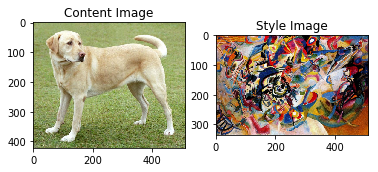

In [15]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

## Fast Style Transfer using TF-Hub

This tutorial demonstrates the original style-transfer algorithm. Which optimizes the image content to a particular style. Before getting into the details let's see how the [TensorFlow Hub](https://tensorflow.org/hub) module does:

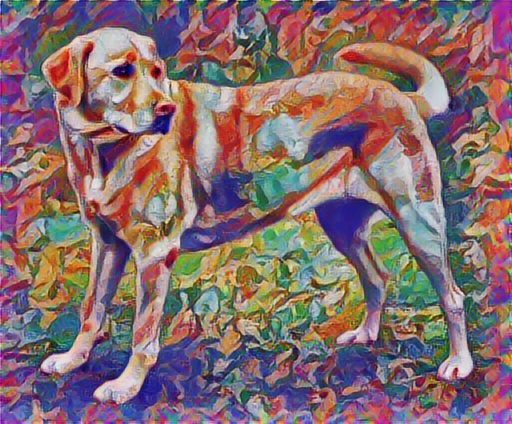

In [16]:
import tensorflow_hub as hub
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/1')
stylized_image = hub_module(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [17]:
mobnet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')

print()
for layer in mobnet.layers:
  print(layer.name)

/home/ayesha/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



input_1
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand
blo

Choose intermediate layers from the network to represent the style and content of the image:


In [18]:
# Content layer where will pull our feature maps
content_layers = ['block_5_expand_BN'] 

# Style layer of interest
style_layers = ['block_1_expand',
                'block_2_expand',
                'block_3_expand', 
                'block_4_expand', 
                'block_5_expand']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Build the model 

The networks in `tf.keras.applications` are designed so you can easily extract the intermediate layer values using the Keras functional API.

To define a model using the functional API, specify the inputs and outputs:

`model = Model(inputs, outputs)`

This following function builds a MobileNetV2 model that returns a list of intermediate layer outputs:

In [19]:
def mobnet_layers(layer_names):
  """ Creates a mobnet model that returns a list of intermediate output values."""
  # Load our model. Load pretrained Mobnet, trained on imagenet data
  mobnet = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet')
  mobnet.trainable = False
  
  outputs = [mobnet.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([mobnet.input], outputs)
  return model

And to create the model:

In [20]:
style_extractor = mobnet_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block_1_expand
  shape:  (1, 168, 256, 96)
  min:  -36.058865
  max:  38.22583
  mean:  0.15012302

block_2_expand
  shape:  (1, 84, 128, 144)
  min:  -23.022594
  max:  24.565767
  mean:  0.14403357

block_3_expand
  shape:  (1, 84, 128, 144)
  min:  -43.793957
  max:  37.809097
  mean:  0.16329658

block_4_expand
  shape:  (1, 42, 64, 192)
  min:  -19.1169
  max:  16.085794
  mean:  0.109131016

block_5_expand
  shape:  (1, 42, 64, 192)
  min:  -18.20405
  max:  15.333697
  mean:  -0.030412665



## Calculate style

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calcualted for a particular layer as:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

This can be implemented concisely using the `tf.linalg.einsum` function:

In [21]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

## Extract style and content


Build a model that returns the style and content tensors.

In [22]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.mobnet =  mobnet_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.mobnet.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    outputs = self.mobnet(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [23]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())


Styles:
   block_1_expand
    shape:  (1, 96, 96)
    min:  -9.991786
    max:  12.621192
    mean:  0.0131167155

   block_2_expand
    shape:  (1, 144, 144)
    min:  -8.362657
    max:  9.467499
    mean:  0.03186849

   block_3_expand
    shape:  (1, 144, 144)
    min:  -25.436186
    max:  33.016495
    mean:  0.10021262

   block_4_expand
    shape:  (1, 192, 192)
    min:  -6.1489515
    max:  8.780952
    mean:  0.0053584776

   block_5_expand
    shape:  (1, 192, 192)
    min:  -10.755814
    max:  15.27308
    mean:  0.022515416

Contents:
   block_5_expand_BN
    shape:  (1, 52, 64, 192)
    min:  -8.199804
    max:  7.357612
    mean:  0.5829649


## Run gradient descent

With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:

In [24]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

Define a `tf.Variable` to contain the image to optimize. To make this quick, initialize it with the content image (the `tf.Variable` must be the same shape as the content image):

In [25]:
image = tf.Variable(content_image)

Since this is a float image, define a function to keep the pixel values between 0 and 1:

In [26]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

Create an optimizer. The paper recommends LBFGS, but `Adam` works okay, too:

In [27]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

To optimize this, use a weighted combination of the two losses to get the total loss:

In [28]:
style_weight=1e-2
content_weight=1e4

In [29]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

Use `tf.GradientTape` to update the image.

In [30]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

Now run a few steps to test:

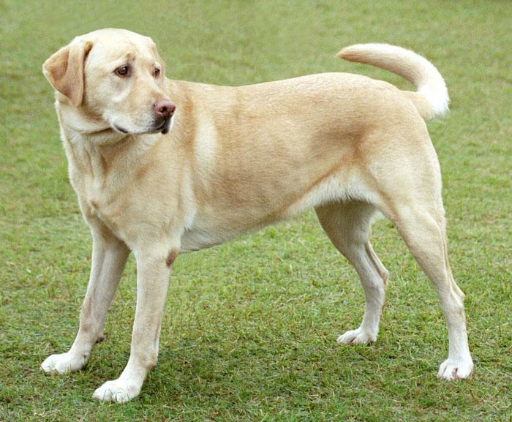

In [31]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Since it's working, perform a longer optimization:

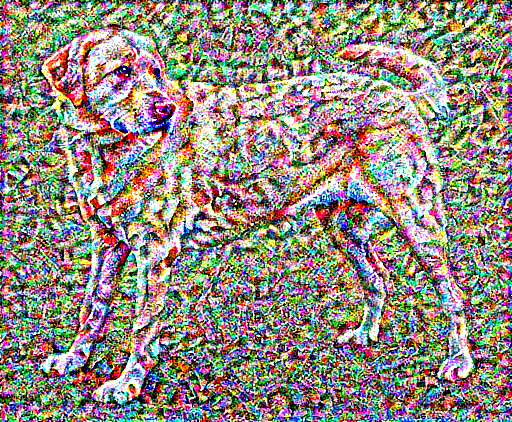

Train step: 500
Total time: 232.3


In [48]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 50

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))